In [1]:
from Distillation_disc_cont import simulator
from Actor_Critic import Agent
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
import dill

Using TensorFlow backend.


In [ ]:
#dill.load_session('Agent.db')

In [ ]:
%autoreload

In [2]:
env = simulator()
agent = Agent(env = env, alpha = 1e-6, beta = 1e-7, gamma = 0.99)
agent.actor.summary()
#agent.critic.summary()
#agent.policy.summary()

W0929 18:18:20.683945 19976 deprecation_wrapper.py:119] From C:\Users\meatrobot\Anaconda3\envs\RL\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0929 18:18:20.705886 19976 deprecation_wrapper.py:119] From C:\Users\meatrobot\Anaconda3\envs\RL\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0929 18:18:20.708878 19976 deprecation_wrapper.py:119] From C:\Users\meatrobot\Anaconda3\envs\RL\lib\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

D:\Github\Discontinuous and Continuous\Actor_Critic.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  actor = Model(input = [input, delta], output = [policy_discrete_probs, policy_continuous])
W09

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 6)            0                                            
__________________________________________________________________________________________________
fc1 (Dense)                     (None, 20)           140         Input[0][0]                      
__________________________________________________________________________________________________
fc2 (Dense)                     (None, 20)           420         fc1[0][0]                        
__________________________________________________________________________________________________
fc3 (Dense)                     (None, 20)           420         fc2[0][0]                        
____________________________________________________________________________________________

D:\Github\Discontinuous and Continuous\Actor_Critic.py:64: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  policy = Model(input = [input], output = [policy_discrete_probs, policy_continuous])


In [3]:
score_history = []
num_episodes = int(1e3)
for i in range(num_episodes):
	done = False
	
	state = env.reset()
	score = 0
	
	while not done:
		action = agent.choose_action(state)
		next_state, reward, done, info = env.step(action)
		agent.learn(state,  action, reward, next_state, done)
		state = next_state
		score += reward
	
	score_history.append(score)
	avg_score = np.mean(score_history[-100:]) #average of last 100 scores
	if i%100 == 0:
		print(f'episode {i}, avg_score {avg_score}')
        


W0929 18:18:34.532082 19976 deprecation_wrapper.py:119] From C:\Users\meatrobot\Anaconda3\envs\RL\lib\site-packages\keras\backend\tensorflow_backend.py:3005: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0929 18:18:34.815118 19976 deprecation.py:323] From C:\Users\meatrobot\Anaconda3\envs\RL\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
D:\Github\Discontinuous and Continuous\Distillation_disc_cont.py:74: RuntimeWarning: invalid value encountered in log
  N =  np.log(LK_D/(1-LK_D) * (1-LK_B)/LK_B)/np.log(self.relative_volatility[Light_Key])
D:\Github\Discontinuous and Continuous\Distillation_disc_cont.py:60: RuntimeWarning: invalid value encountered in double_scalars
  LK_D = tops[Light_Key]/sum(tops)


episode 0, avg_score -8075.004248281315


D:\Github\Discontinuous and Continuous\Distillation_disc_cont.py:61: RuntimeWarning: invalid value encountered in double_scalars
  LK_B = bots[Light_Key]/sum(bots)


episode 100, avg_score -10340.228171208204
episode 200, avg_score -9893.534067442519
episode 300, avg_score -10010.875101803296
episode 400, avg_score -9964.307469221432
episode 500, avg_score -10118.781860253897
episode 600, avg_score -10048.447215005122
episode 700, avg_score -10490.195570096808
episode 800, avg_score -9762.60796913538
episode 900, avg_score -10246.986488599156


In [4]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

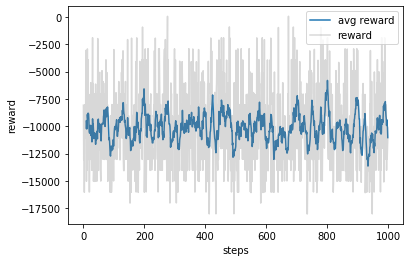

In [5]:
episodes = np.arange(num_episodes)
smoothed_rews = running_mean(score_history, 10)
plt.plot(episodes[-len(smoothed_rews):], smoothed_rews)
plt.plot(episodes, score_history,color='grey', alpha=0.3)
plt.xlabel("steps")
plt.ylabel("reward")
plt.legend(["avg reward", "reward"])

In [6]:
#test agent
state = env.reset()
done = False
while done == False:
    state = state[np.newaxis, :]
    action_discrete, action_continuous = agent.policy.predict(state)
    action_discrete = np.argmax(action_discrete)
    action = action_discrete, action_continuous
    
    state, reward, done, info = env.step(action)
    print(f'action LK: {action_discrete}, action split: {action_continuous[0]}, reward: {reward}')

action LK: 2, action split: [0.6062644], reward: -0.38714392649682877
action LK: 2, action split: [0.63571286], reward: -1000
action LK: 2, action split: [0.65046656], reward: -3.066492757477896
action LK: 2, action split: [0.6470249], reward: -1000
action LK: 2, action split: [0.6637741], reward: -3.540672564695073
action LK: 2, action split: [0.6502862], reward: -1000
action LK: 2, action split: [0.664428], reward: -3.9183010419601985
action LK: 2, action split: [0.65330344], reward: -1000
action LK: 2, action split: [0.6629934], reward: -4.291623586067822
action LK: 2, action split: [0.6556443], reward: -1000
action LK: 2, action split: [0.6614028], reward: -4.674750548960599


In [7]:
env.stream_table

[array([9.1, 6.8, 9.1, 6.8, 6.8, 6.8]),
 array([9.1       , 6.8       , 5.5170064 , 2.67740202, 0.        ,
        0.        ]),
 array([0.        , 0.        , 3.5829936 , 4.12259798, 6.8       ,
        6.8       ]),
 array([9.1       , 6.8       , 3.50723195, 0.97534311, 0.        ,
        0.        ]),
 array([0.        , 0.        , 2.00977445, 1.70205891, 0.        ,
        0.        ]),
 array([0.        , 0.        , 2.33061743, 1.44098592, 0.        ,
        0.        ]),
 array([0.        , 0.        , 1.25237617, 2.68161206, 6.8       ,
        6.8       ]),
 array([9.1       , 6.8       , 2.26926661, 0.34427181, 0.        ,
        0.        ]),
 array([0.        , 0.        , 1.23796535, 0.6310713 , 0.        ,
        0.        ]),
 array([0.        , 0.        , 0.83129483, 0.90162748, 0.        ,
        0.        ]),
 array([0.        , 0.        , 0.42108134, 1.77998458, 6.8       ,
        6.8       ]),
 array([9.1       , 6.8       , 1.47567272, 0.12039661, 0.  

In [9]:
action_discrete, action_continuous = agent.policy.predict(state[np.newaxis, :])

In [ ]:
#dill.dump_session('Agent.db')